In [23]:
import os
import glob
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [24]:
SEED = 1
FOLDS = 3
EPOCHS = 32
BATCH_SIZE = 64
NUM_CLASSES = 1
VERBOSE_LEVEL = 2
SAVE_OUTPUT = False
LEARNING_RATE = 1e-4
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

CWD = os.getcwd()
AUTOTUNE = tf.data.experimental.AUTOTUNE

GOOGLE_COLAB = False
if CWD == "/content":
    GOOGLE_COLAB = True

print ('Running in colab:', GOOGLE_COLAB)


Running in colab: False


In [25]:
def seed_all(seed):
    ''' A function to seed everything for getting reproducible results. '''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_KERAS'] = str(seed)
    tf.random.set_seed(seed)
    
seed_all(1)

In [26]:
MIXED_PRECISION = True
XLA_ACCELERATE = True
GPUS = 0

print("Tensorflow version " + tf.__version__)

print('Using default strategy for CPU and single GPU')
strategy = tf.distribute.get_strategy()

GPUS = len(tf.config.experimental.list_physical_devices('GPU'))
if GPUS == 0:
    DEVICE = 'CPU'
else:
    DEVICE = 'GPU'
    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

REPLICAS = strategy.num_replicas_in_sync
STRATEGY = strategy

# Update BATCH_SIZE
BATCH_SIZE = BATCH_SIZE * REPLICAS

print("REPLICAS", REPLICAS)
print("DEVICE", DEVICE)

Tensorflow version 2.3.1
Using default strategy for CPU and single GPU
REPLICAS 1
DEVICE CPU


In [27]:
base_path = '/kaggle/input/siim-isic-melanoma-classification'
path_to_images = '/kaggle/input/siim-isic-melanoma-classification/jpeg' 
image_type = ".jpg"

# check on which system we are
if os.path.exists(CWD + '/data'):
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

elif GOOGLE_COLAB:
    CWD = "/content/melanoma-classification"
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

change base_path to  /workspaces/melanoma-classification/data


In [28]:
# get the data
train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))

# add the image_path
train['image_path'] = train['image_name'].apply(lambda x: path_to_images + "/train/" + x + image_type)
test['image_path'] = test['image_name'].apply(lambda x: path_to_images + "/test/" + x + image_type)

# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','image_name','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','image_name','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

# Get a balanced dataset
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20 %; 8 = ~11%; 12 = ~8%
balance = 12
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
print("samples in train", train['target'].sum()/len(train))

print("rows in train", train.shape[0])
print("rows in test", test.shape[0])

samples in train 0.07692307692307693
rows in train 7592
rows in test 10982


In [29]:
train.dtypes

patient_id                object
age_approx                 int64
target                     int64
image_path                object
sex_female                 int64
sex_male                   int64
anatom_head/neck           int64
anatom_lower extremity     int64
anatom_oral/genital        int64
anatom_palms/soles         int64
anatom_torso               int64
anatom_upper extremity     int64
dtype: object

In [30]:
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.1, 
        width_shift_range = 0.1, 
        rotation_range = 25, 
        shear_range = 0.1,
        zoom_range = 0.15
    )

    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='target',
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    return train_gen

In [31]:
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='target',
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    return val_gen

Found 22 validated image filenames.


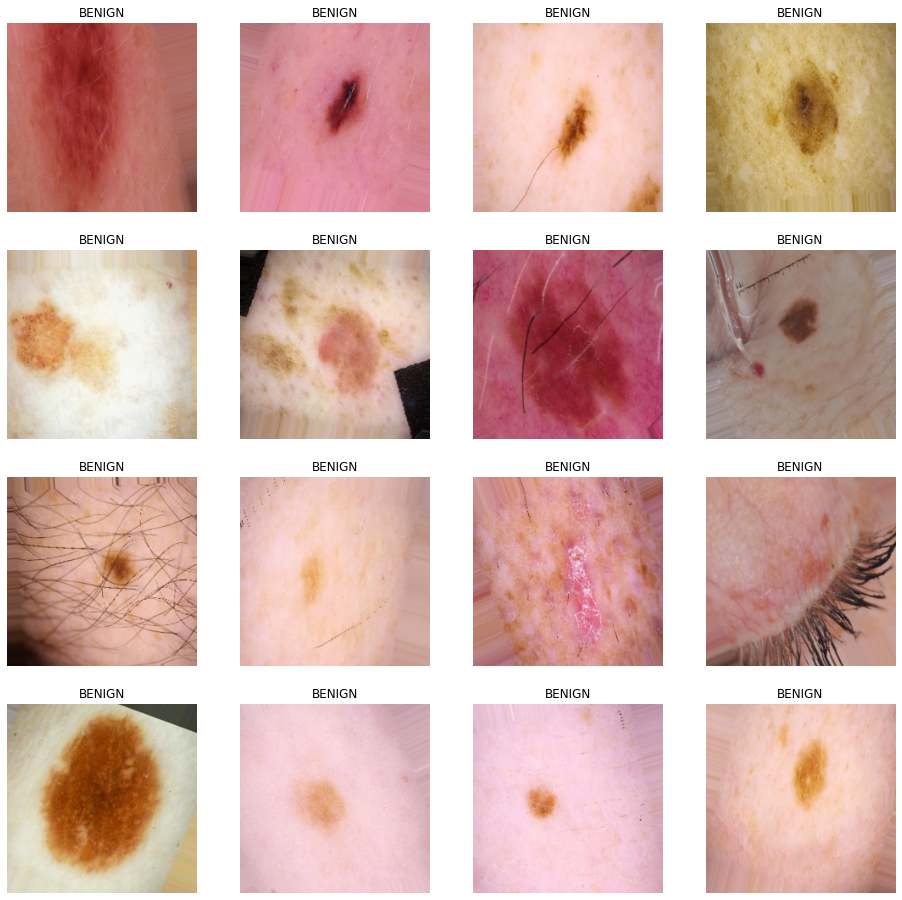

In [32]:
train_gen = get_training_gen(train.sample(50))
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('MALIGNANT')
    else:
        c_ax.set_title('BENIGN')
    c_ax.axis('off')

In [33]:
def save_history(history, timestamp):
    """Helper function to save a png image of the loss and accuracy
    Args:
        history ([tf history]): The history object of a tf model
    """
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    if SAVE_OUTPUT:
        plt.savefig("./" + timestamp + "-history.png")
        with open("./" + timestamp + "-history.json", 'w') as f:
            json.dump(history, f)

def get_prediction(img_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score = score.numpy()
    return score[1]

In [34]:
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

weight_path = "./" + timestamp + "-model.hdf5"

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=VERBOSE_LEVEL,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    overwrite=True
)

early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [checkpoint, early]

In [35]:
def create_model():
    print("create model")

    res_model = ResNet50(weights='imagenet', include_top=False, input_tensor=tf.keras.Input(shape=INPUT_SHAPE))
    for layer in res_model.layers[:143]:
        layer.trainable = False

    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(res_model)  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. This is for combining features that the res_model model has recognized in the image.
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data e.g. the test-set.
    model.add(layers.Dense(512, activation='relu', input_dim=INPUT_SHAPE))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

In [36]:
def create_experiment_model():
    print("create experiment model")
    model = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(INPUT_SHAPE)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [37]:
# reduce the df and batch size when running on a cpu
if DEVICE == 'CPU':
    print("reduce the amount of data and the number of epchs and folds because of cpu runtime")
    # take 30% of the available data
    train = train.sample(int(train.shape[0] * 0.3))
    EPOCHS = 3
    FOLDS = 2

reduce the amount of data and the number of epchs and folds because of cpu runtime


In [38]:
## K-fold Cross Validation model evaluation

# Define the model architecture
model = False
if DEVICE == 'CPU':
    model = create_experiment_model()
else:
    model = create_model()

OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

print("Start training with", train.shape[0], "rows")
print(" ")

# extract the y variable
y_set = train[['target']]

x_set_columns = list(filter(lambda c: c != 'target', train.columns))
x_set = train[x_set_columns]

#  Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# save all model histories
histories = []

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

fold_no = 1
for train_index, validation_index in kfold.split(x_set, y_set):
    print(f'Training for fold {fold_no} of {FOLDS}')

    training_df = train[train.index.isin(train_index)]
    validation_df = train[train.index.isin(validation_index)]

    print("rows in training_df", training_df.shape[0])
    print("rows in validation_df", validation_df.shape[0])
    print("samples in train", training_df['target'].sum()/len(training_df))
    print("samples in validation", validation_df['target'].sum()/len(validation_df))

    train_gen = get_training_gen(training_df)
    val_gen = get_validation_gen(validation_df)

    valX, valY = val_gen.next() 

    # when on a cpu, do not save the model data
    if DEVICE == 'CPU':
        history = model.fit(
            train_gen, 
            validation_data=(valX, valY), 
            epochs=EPOCHS, 
            verbose=VERBOSE_LEVEL
        )
    else:
        history = model.fit(
            train_gen, 
            validation_data=(valX, valY), 
            epochs=EPOCHS, 
            callbacks=callbacks_list, 
            verbose=VERBOSE_LEVEL
        )

    # save model history
    histories.append(history)

    # Generate generalization metrics
    scores = model.evaluate(valX, valY, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    print(" ")
    print(" ")

    # Increase fold number
    fold_no = fold_no + 1

create experiment model
Start training with 2277 rows
 
Training for fold 1 of 2
rows in training_df 91
rows in validation_df 70
samples in train 0.04395604395604396
samples in validation 0.05714285714285714
Found 91 validated image filenames.
Found 70 validated image filenames.
Epoch 1/3
2/2 - 5s - loss: 14.5789 - accuracy: 0.0440 - val_loss: 14.2962 - val_accuracy: 0.0625
Epoch 2/3
2/2 - 3s - loss: 14.5789 - accuracy: 0.0440 - val_loss: 14.2962 - val_accuracy: 0.0625
Epoch 3/3
2/2 - 2s - loss: 14.5789 - accuracy: 0.0440 - val_loss: 14.2962 - val_accuracy: 0.0625
Score for fold 1: loss of 14.296160697937012; accuracy of 6.25%
 
 
Training for fold 2 of 2
rows in training_df 70
rows in validation_df 91
samples in train 0.05714285714285714
samples in validation 0.04395604395604396
Found 70 validated image filenames.
Found 91 validated image filenames.
Epoch 1/3
2/2 - 4s - loss: 14.3779 - accuracy: 0.0571 - val_loss: 15.0110 - val_accuracy: 0.0156
Epoch 2/3
2/2 - 4s - loss: 14.3779 - acc

In [39]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 14.296160697937012 - Accuracy: 6.25%
------------------------------------------------------------------------
> Fold 2 - Loss: 15.010969161987305 - Accuracy: 1.5625%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 3.90625 (+- 2.34375)
> Loss: 14.653564929962158
------------------------------------------------------------------------


In [40]:
# create a empty history object in which we can save all of our training histories
history = dict()

# prepare the history object
for key in histories[0].history.keys():
    history[key] = []

# add the data
for hist in histories:
    for key in hist.history.keys():
        history[key].append(hist.history[key])

# flatten the metric lists
for key in histories[0].history.keys():
    history[key] = sum(history[key], [])

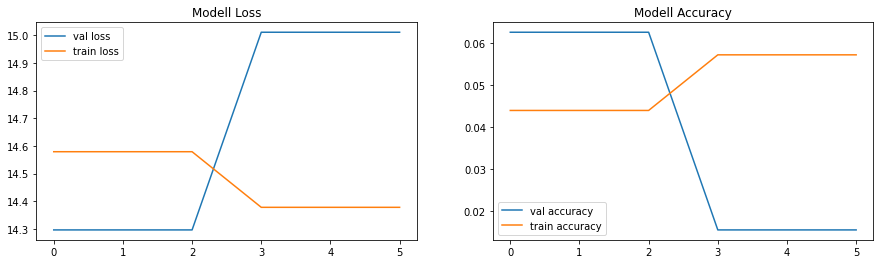

In [41]:
save_history(history, timestamp)
if SAVE_OUTPUT:
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

In [42]:
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

(-0.5, 223.5, 223.5, -0.5)

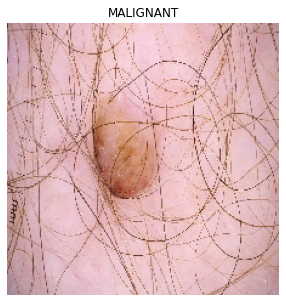

In [43]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
score = score.numpy()
score = int(score[0])

finding = "BENIGN"
if score == 1:
    finding = "MALIGNANT"

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(finding)
plt.axis("off")

In [44]:
if SAVE_OUTPUT:
    data=[]
    for i in tqdm(range(test_df.shape[0])):
        image_path = test_df.iloc[i].image_path
        image_name = image_path.replace("../input/siim-isic-melanoma-classification/jpeg/test/", "")
        target = get_prediction(image_path)
        data.append([image_name, target])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./" + timestamp + "-submission.csv")

    sub_df.head()